In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import os
os.environ['KMP_DUPLICATE_LIB_OK'] ='True'
torch.manual_seed(1)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
Transform = transform.Compose([transform.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data_mnist/',train=True,download=True,transform=Transform)
testset = torchvision.datasets.MNIST(root='./data_mnist/',train=False,download=True,transform=Transform)
trainloader = DataLoader(trainset,batch_size=64,shuffle=True)
testloader = DataLoader(testset,batch_size=64,shuffle=True)

trainset1 = torchvision.datasets.MNIST(root='./data_mnist/',train=True,download=True,transform=Transform)
testset1 = torchvision.datasets.MNIST(root='./data_mnist/',train=False,download=True,transform=Transform)
trainloader1 = DataLoader(trainset,batch_size=1024,shuffle=True)
testloader1 = DataLoader(testset,batch_size=1024,shuffle=True)

In [4]:
class my_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.conv2 = nn.Conv2d(10,16,3)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(16*5*5,32)
        self.act3 = nn.ReLU()
        
        self.fc4 = nn.Linear(32,10)

        self.cross_ent = nn.CrossEntropyLoss()
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        
        x = self.flat(x)
        
        x = self.act3(self.fc3(x))
        x = self.fc4(x)
        return x

In [5]:
def Train_(model,TL,lr):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for _ in range(Epoch):
        for input, label in TL:
            input, label = input.to(device), label.to(device)
            y_hat = model(input).to(device)
            loss = model.cross_ent(y_hat,label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    return model

def find_loss(model,L):
    model.eval()
    acc = 0
    count = 0
    count_ = 0
    l = 0
    for input, label in L:
        input, label = input.to(device), label.to(device)
        y_hat = model(input).to(device)
        loss = model.cross_ent(y_hat,label)
        l += loss
        acc += (torch.argmax(y_hat,dim=1) == label).float().sum()
        count += len(label)
        count_ += 1
    l /= count_
    acc /= count
    return acc,l

Run for lr = 0.010..


100%|██████████| 20/20 [02:56<00:00,  8.84s/it]


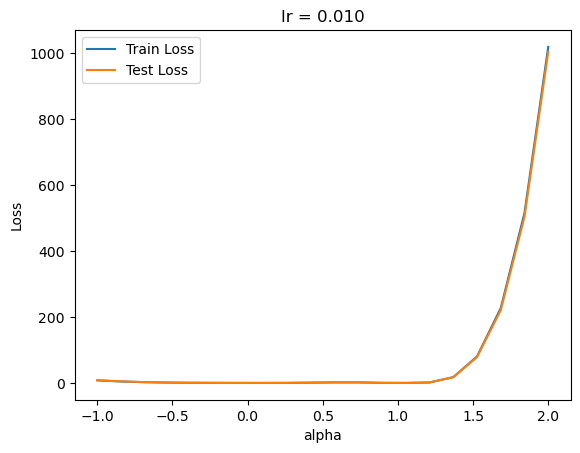

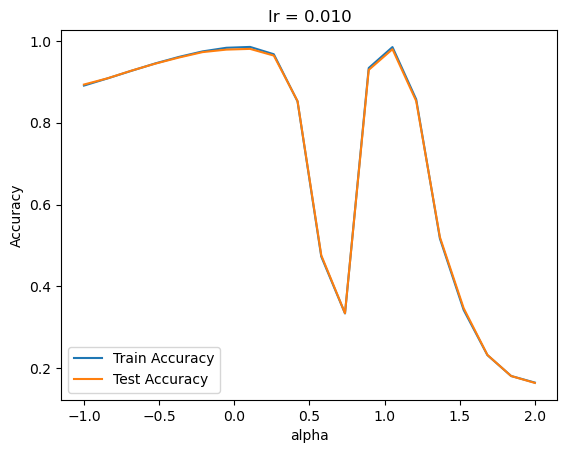

Run for lr = 0.001..


100%|██████████| 20/20 [02:57<00:00,  8.86s/it]


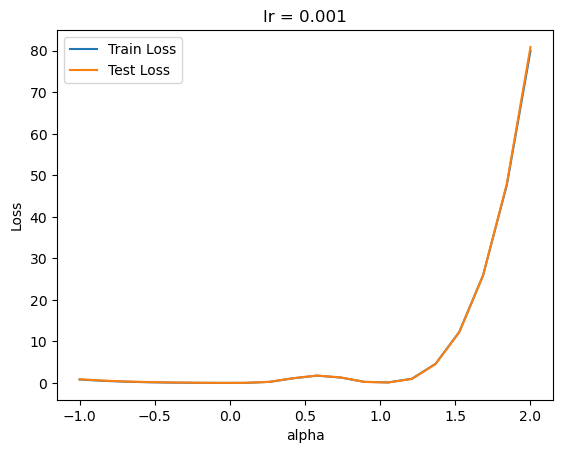

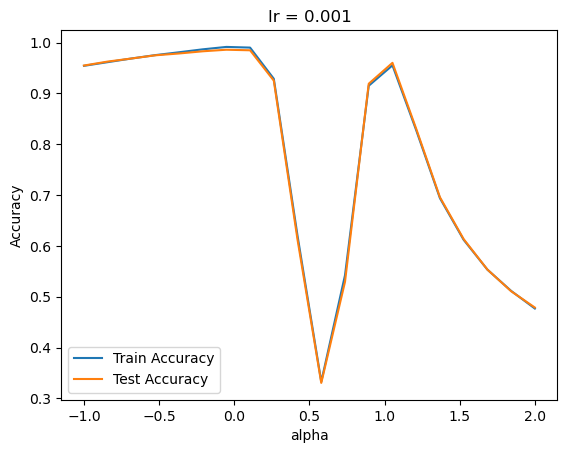

In [6]:
if __name__=='__main__':
    Epoch = 10
    alpha = np.linspace(-1,2,20)
    learning_rate = [1e-2, 1e-3]
    
    for lr in learning_rate:
        print('Run for lr = {:.3f}..'.format(lr))
        model1 = my_cnn().to(device)
        model2 = my_cnn().to(device)
        model1 = Train_(model1,trainloader,lr)
        model2 = Train_(model2,trainloader1,lr)
        model1_params = nn.utils.parameters_to_vector(model1.parameters())
        model2_params = nn.utils.parameters_to_vector(model2.parameters())

        
        train_loss=[]; test_loss=[]
        train_acc=[]; test_acc=[]
        with torch.no_grad():
            for i in tqdm(range(len(alpha))):
                model = my_cnn().to(device)
                theta = (1-alpha[i])*model1_params + alpha[i]*model2_params
                nn.utils.vector_to_parameters(theta, model.parameters())
                aux = find_loss(model,trainloader)
                train_acc.append(aux[0].cpu().item())
                train_loss.append(aux[1].cpu().item())
                aux = find_loss(model,testloader)
                test_acc.append(aux[0].cpu().item())
                test_loss.append(aux[1].cpu().item())
                del model

        plt.plot(alpha, train_loss, label='Train Loss')
        plt.plot(alpha, test_loss, label='Test Loss')
        plt.xlabel('alpha')
        plt.ylabel('Loss')
        plt.title('lr = {:.3f}'.format(lr))
        plt.legend()
        plt.show()

        plt.plot(alpha, train_acc, label='Train Accuracy')
        plt.plot(alpha, test_acc, label='Test Accuracy')
        plt.xlabel('alpha')
        plt.ylabel('Accuracy')
        plt.title('lr = {:.3f}'.format(lr))
        plt.legend()
        plt.show()
        
        gc.collect()
        torch.cuda.empty_cache()